# Test Time Augmention

After training an ensemble or any other bayesian neural network on a dataset, we create an augmented version of the dataset to test on. This augmented dataset allows us probe our model's confidence in predictions. In this example we are working with the MNIST dataset, and apply a rotation to the original dataset at test time. By plotting the change in logits and probabilities over a range of rotations we can obeserve our model's uncertainty when viewing new data.

## Rotated MNIST at test time

##### Dataset

In [1]:
import torch
import copy
import os
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from experiments.nns.bdl import SelectMNISTDataset


# Define the path to directory containing MNIST
mnist_directory = os.path.abspath(os.path.join(os.path.dirname(os.path.abspath("uncertainty.ipynb")), "..","..","..","..","..","..","..", "/usr/data1/vision/data/"))


# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load the MNIST training dataset
# train_dataset = datasets.MNIST(root=mnist_directory, train=True, download=False, transform=transform)
train_dataset = SelectMNISTDataset(root=mnist_directory, train=True, numbers = [0,1,2,3,4,5,6,7,8,9], num_entries_per_digit=10, transform=transform)

## Creating rotated dataset

In [2]:
import torch
import copy
import os
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from experiments.nns.bdl import CustomMNISTDataset

# Choose what number we would like to test
selected_numbers = [1]

rotation_angles = []
for i in range(12):
    rotation_angles.append(i*5.5)
def get_rotated_mnist_dataset(degrees):
    rotate_transform = transforms.Compose([
            transforms.RandomRotation(degrees=(degrees, degrees), fill=(0,)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
    rotated_dataset = CustomMNISTDataset(root=mnist_directory, numbers=selected_numbers, train=False, transform=rotate_transform)
    rotated_loader = DataLoader(rotated_dataset, batch_size=512, shuffle=False)
    return rotated_dataset, rotated_loader
rotated_datasets = []
rotated_loaders = []

for angle in rotation_angles:
    rotated_dataset, rotated_loader = get_rotated_mnist_dataset(angle)
    rotated_datasets.append(rotated_dataset)
    rotated_loaders.append(rotated_loader)


test_dataset = CustomMNISTDataset(root=mnist_directory, numbers=selected_numbers, train=False, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

## Training

In [3]:
import torch
from torch.utils.data import DataLoader
import push.bayes.ensemble
from experiments.nns.lenet.lenet import LeNet


# Create data loaders
batch_size = 512
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
epochs = 50
n = 25
lr = 0.01

ensemble = push.bayes.ensemble.train_deep_ensemble(
        train_loader,
        torch.nn.CrossEntropyLoss(),
        epochs,
        LeNet,
        num_devices=2,
        num_ensembles=n,
        cache_size=25
    )

100%|██████████| 50/50 [00:18<00:00,  2.75it/s, loss=tensor(0.0941)]


In [4]:
import push.bayes.swag

pretrain_epochs = 25
swag_epochs = 25
swag = push.bayes.swag.train_mswag(
    train_loader,
    torch.nn.CrossEntropyLoss(),
    pretrain_epochs,
    swag_epochs,
    LeNet,
    num_devices = 2,
    num_models = n,
    lr = lr,
)

100%|██████████| 25/25 [00:38<00:00,  1.56s/it, loss=tensor(0.3508)]


In [5]:
import push.bayes.stein_vgd

svgd = push.bayes.stein_vgd.train_svgd(
    train_loader,                       # Dataloader
    torch.nn.CrossEntropyLoss(),        # Loss Fn
    epochs,                             # Epochs
    10,                                  # Number of particles
    LeNet,                              # NN
    lengthscale = 0.25,                  # Lengthscale
    lr = 3e-1,                          # Learning Rate
    num_devices = 2,                    # Number of devices
)

100%|██████████| 50/50 [02:28<00:00,  2.96s/it, loss=tensor(2.2890)]


## Helper functions for output and plots

In [6]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

ensemble_outputs = []
for loader in rotated_loaders:
    ensemble_outputs.append(ensemble.posterior_pred(loader, f_reg=False, mode=["mode","logits","prob"]))

swag_outputs = []
for loader in rotated_loaders:
    swag_outputs.append(swag.posterior_pred(loader, f_reg=False, mode=["mode","logits","prob"]))

svgd_outputs = []
for loader in rotated_loaders:
    svgd_outputs.append(svgd.posterior_pred(loader, f_reg=False, mode=["mode","logits","prob"]))

def get_mode(output, mode):
    return output[mode]

# Display rotated images
# num_images_to_display = 
idx_image_to_display = 4
imgs = []
lbls = []
for dataset in rotated_datasets:
    rotated_loader_small = DataLoader(dataset, batch_size=512, shuffle=False)
    for images, labels in rotated_loader_small:
        imgs.append(images[idx_image_to_display])
        lbls.append(labels[idx_image_to_display])
        break

def offset_image(coord, i, ax, low_img, low_index, zoom):
    '''mnist_classification_mc_dropout.ipynb [1]'''
    img = imgs[i]
    im = OffsetImage(img.squeeze(), zoom=zoom)
    im.image.axes = ax

    ab = AnnotationBbox(
        im,
        (coord, low_img),
        xybox=(0.0, low_index),
        frameon=False,
        boxcoords="offset points",
    )
    ax.add_artist(ab)

In [50]:
import matplotlib.pyplot as plt
import numpy as np

def plot_logits(outputs, title, idx_image_to_display):
    fig, ax = plt.subplots(1)
    zoom = 0.4
    index = np.arange(len(outputs))
    for i, output in enumerate(outputs):
        ax.eventplot(
            get_mode(output, "logits")[:,:,(1,3,7)][idx_image_to_display][:,(0)],
            orientation="vertical",
            lineoffsets=i,
            linelengths=0.8,
            colors="green",
            alpha=0.75,
        )
        ax.eventplot(
            get_mode(output, "logits")[:,:,(1,3,7)][idx_image_to_display][:,(1)],
            orientation="vertical",
            lineoffsets=i,
            linelengths=0.8,
            colors="orange",
            alpha=0.75,
        )
        ax.eventplot(
            get_mode(output, "logits")[:,:,(1,3,7)][idx_image_to_display][:,(2)],
            orientation="vertical",
            lineoffsets=i,
            linelengths=0.8,
            colors="blue",
            alpha=0.6,
        )

    ax.set_xticks(index)
    ax.set_xticklabels(index + 1)
    ax.tick_params(axis="x", which="major", pad=8)
    ax.set_ylabel("Logits")
    l, h = ax.get_ylim()
    for i in index:
        offset_image(i, i, ax, l, l - 5, zoom)
    ax.legend(["1", "5", "7"], bbox_to_anchor=(0.6, 1.0))
    fig.suptitle(title, fontsize=16, y=1.05)
    plt.show()

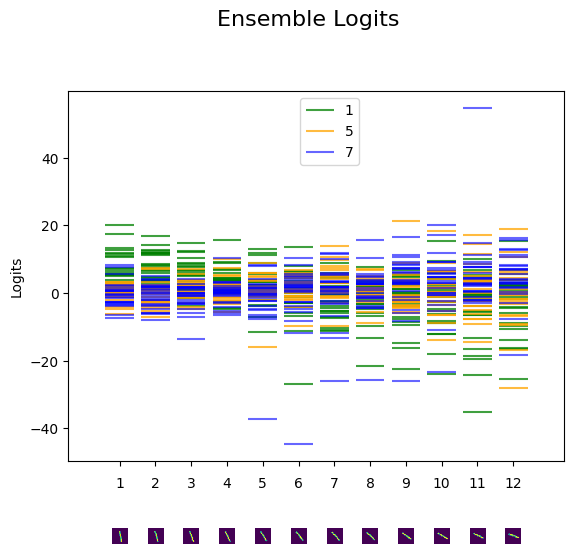

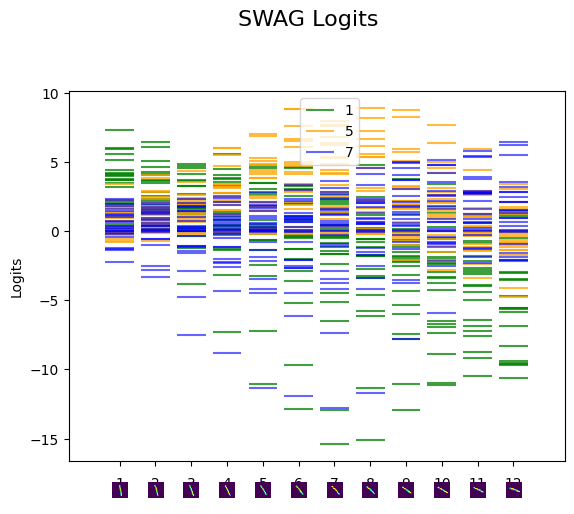

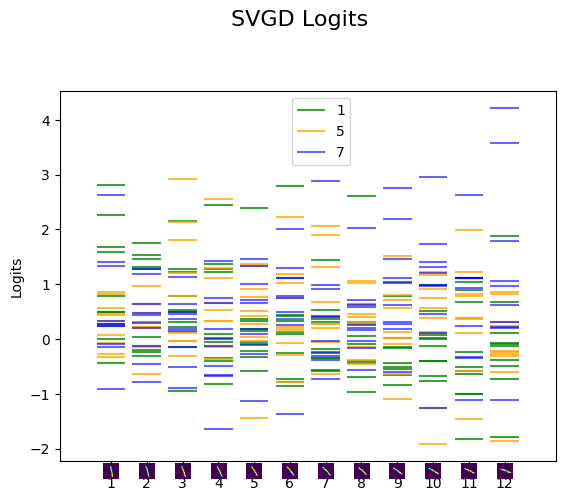

In [8]:
plot_logits(ensemble_outputs, "Ensemble Logits", idx_image_to_display)
plot_logits(swag_outputs, "SWAG Logits", idx_image_to_display)
plot_logits(svgd_outputs, "SVGD Logits", idx_image_to_display)

In [49]:
def plot_probability(outputs, title, idx_image_to_display):
    fig, ax = plt.subplots(1)
    zoom = 0.4
    # else:
    #     plt.rcParams["font.size"] = 16
    #     fig, ax = plt.subplots(1, figsize=(12, 6))
    #     zoom = 1
    index = np.arange(len(outputs))
    for i, output in enumerate(outputs):
        '''mnist_classification_mc_dropout.ipynb [1]'''
        ax.eventplot(
            get_mode(output, "prob")[:,:,(1,3,7)][idx_image_to_display][:,(0)],
            orientation="vertical",
            lineoffsets=i,
            linelengths=0.8,
            colors="green",
            alpha=0.75,
        )
        ax.eventplot(
            get_mode(output, "prob")[:,:,(1,3,7)][idx_image_to_display][:,(1)],
            orientation="vertical",
            lineoffsets=i,
            linelengths=0.8,
            colors="orange",
            alpha=0.75,
        )
        ax.eventplot(
            get_mode(output, "prob")[:,:,(1,3,7)][idx_image_to_display][:,(2)],
            orientation="vertical",
            lineoffsets=i,
            linelengths=0.8,
            colors="blue",
            alpha=0.6,
        )

    ax.set_xticks(index)
    ax.set_xticklabels(index + 1)
    ax.tick_params(axis="x", which="major", pad=8)
    ax.set_ylabel("Probabilities")
    l, h = ax.get_ylim()
    for i in index:
        offset_image(i, i, ax, l, l - 5, zoom)
    ax.legend(["1", "5", "7"], bbox_to_anchor=(0.6, 1.0))
    fig.suptitle(title, fontsize=16, y=1.05)
    # sns.despine()
    # savefig("mnist_softmax_input", tight_bbox=True, pad=1)
    plt.show()

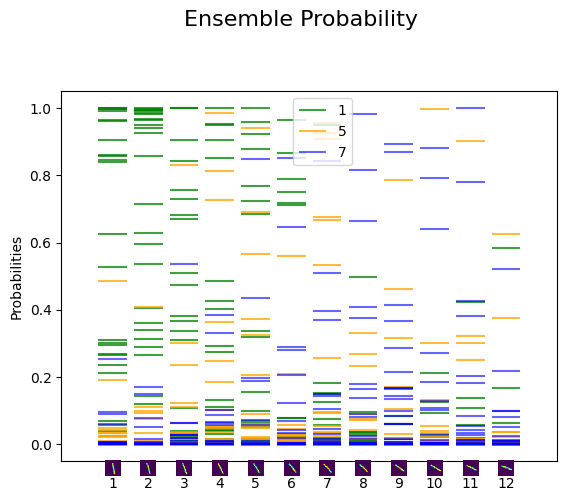

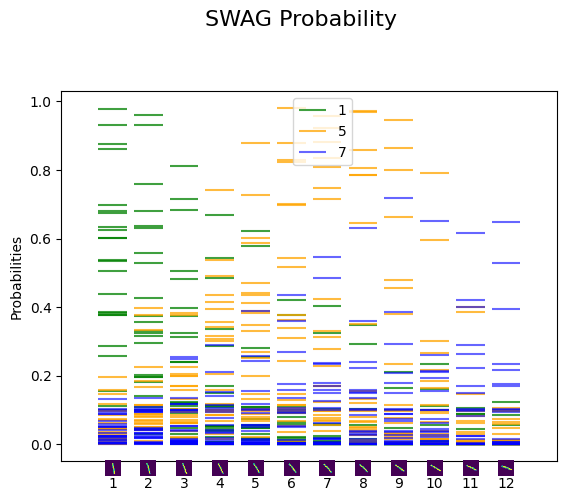

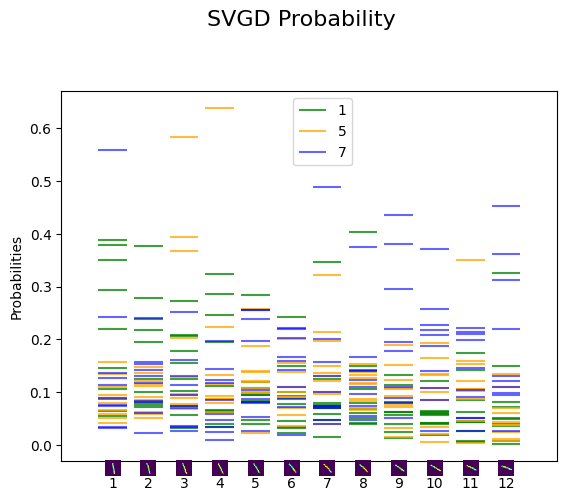

In [10]:
plot_probability(ensemble_outputs, "Ensemble Probability", idx_image_to_display)
plot_probability(swag_outputs, "SWAG Probability", idx_image_to_display)
plot_probability(svgd_outputs, "SVGD Probability", idx_image_to_display)

# Gaussian Noise

In [59]:
import torch
import copy
import os
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from experiments.nns.bdl import CustomMNISTDataset
from experiments.nns.bdl import AddGaussianNoise


# Choose what number we would like to test
selected_numbers = [1]

variances = [0.1,0.2,0.4,0.8,1.0,1.2,1.4,1.6,1.8]


def get_noisy_mnist_dataset(variance, selected_numbers):
    noisy_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    AddGaussianNoise(0., variance)
    ])
    noisy_dataset = SelectMNISTDataset(root=mnist_directory, numbers=selected_numbers, num_entries_per_digit=1, train=False, transform=noisy_transform)
    noisy_loader = DataLoader(noisy_dataset, batch_size=1, shuffle=False)
    return noisy_dataset, noisy_loader
noisy_datasets = []
noisy_loaders = []

for variance in variances:
    noisy_dataset, noisy_loader = get_noisy_mnist_dataset(variance, selected_numbers)
    noisy_datasets.append(noisy_dataset)
    noisy_loaders.append(noisy_loader)

In [60]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

noisy_ensemble_outputs = []
noisy_swag_outputs = []
noisy_svgd_outputs = []
for loader in noisy_loaders:
    noisy_ensemble_outputs.append(ensemble.posterior_pred(loader, f_reg=False, mode=["mode","logits","prob"]))
    noisy_swag_outputs.append(swag.posterior_pred(loader, f_reg=False, mode=["mode","logits","prob"]))
    noisy_svgd_outputs.append(svgd.posterior_pred(loader, f_reg=False, mode=["mode","logits","prob"]))

def get_mode(output, mode):
    return output[mode]

# Display rotated images


In [61]:
# num_images_to_display = 
idx_image_to_display = 0
imgs = []
lbls = []
for dataset in noisy_datasets:
    noisy_loader_small = DataLoader(dataset, batch_size=512, shuffle=False)
    for images, labels in noisy_loader_small:
        imgs.append(images[idx_image_to_display])
        lbls.append(labels[idx_image_to_display])
        break

def offset_image(coord, i, ax, low_img, low_index, zoom):
    '''mnist_classification_mc_dropout.ipynb [1]'''
    img = imgs[i]
    im = OffsetImage(img.squeeze(), zoom=zoom)
    im.image.axes = ax

    ab = AnnotationBbox(
        im,
        (coord, low_img),
        xybox=(0.0, low_index),
        frameon=False,
        boxcoords="offset points",
    )
    ax.add_artist(ab)

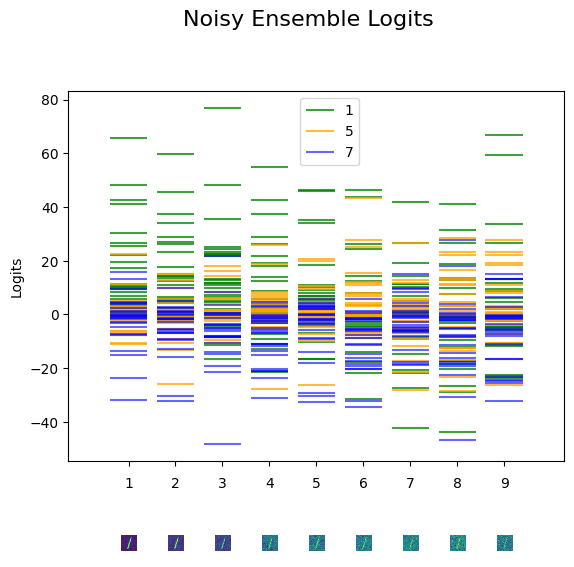

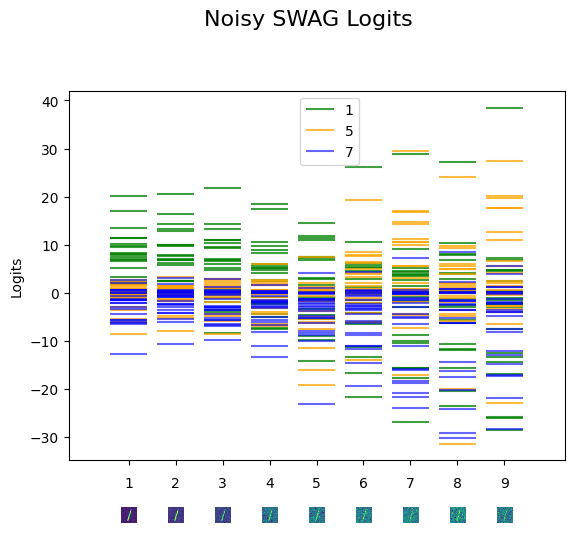

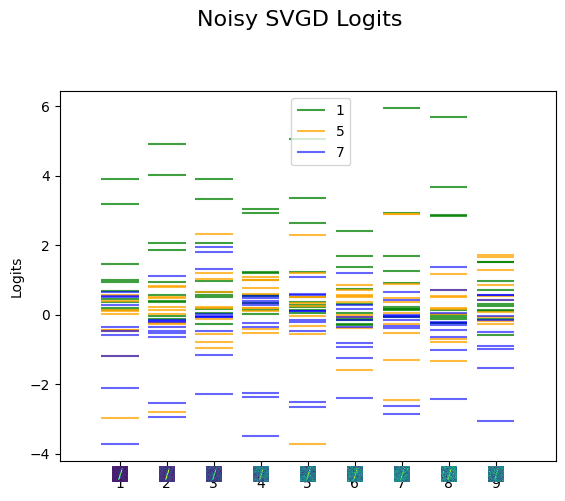

In [62]:
plot_logits(noisy_ensemble_outputs, "Noisy Ensemble Logits", idx_image_to_display)
plot_logits(noisy_swag_outputs, "Noisy SWAG Logits", idx_image_to_display)
plot_logits(noisy_svgd_outputs, "Noisy SVGD Logits", idx_image_to_display)

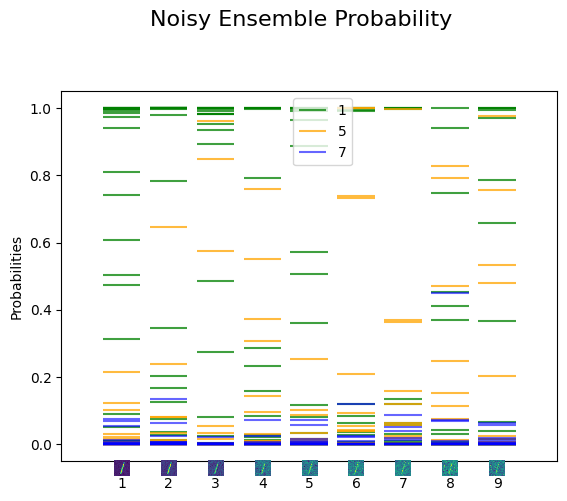

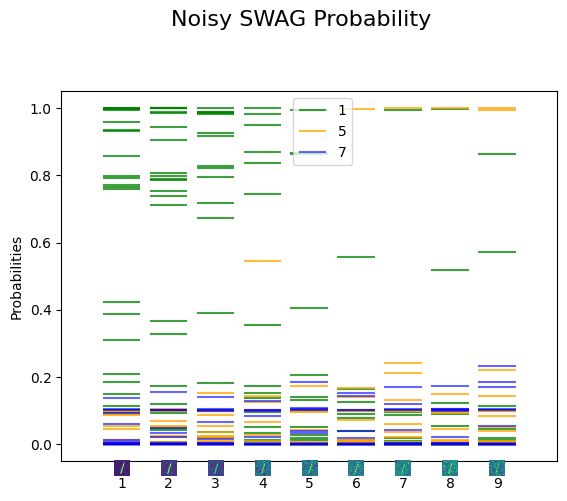

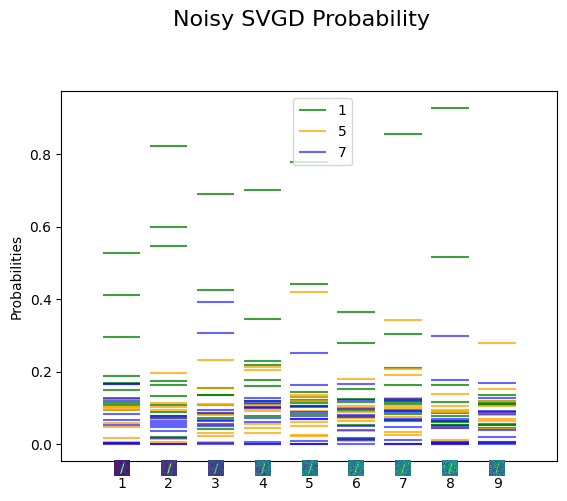

In [63]:
plot_probability(noisy_ensemble_outputs, "Noisy Ensemble Probability", idx_image_to_display)
plot_probability(noisy_swag_outputs, "Noisy SWAG Probability", idx_image_to_display)
plot_probability(noisy_svgd_outputs, "Noisy SVGD Probability", idx_image_to_display)

[1] Kevin Murphy. Probabilistic Machine Learning Advanced Topics. Chapter 17. The MIT Press: Adaptive computation and machine learning series (2023). Cambridge, Massachusetts.